In [27]:
# sklearn
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix
import lightgbm as lgb

# xgboost
from xgboost import XGBClassifier

# utilities
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from utils import * # import all existing functions from file utils.py
%load_ext autoreload
%autoreload 2

# preferences
pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv('../../data_p5/corpus_processed.csv', index_col=0)

In [3]:
df = df[['rating','lem','stem','noun','adj','adv','verb','characters','tokens','words','sentences','avg_word_len','avg_sent_len']]
df.head(3)

,rating,lem,stem,noun,adj,adv,verb,characters,tokens,words,sentences,avg_word_len,avg_sent_len
0,Neutral,"['cafe', 'hotel', 'deal', 'get', 'free', 'brea...","['cafe', 'hotel', 'deal', 'get', 'free', 'brea...",0.474227,0.226804,0.092784,0.154639,1041,97,196,11,5.311224,17.818182
1,Negative,"['went', 'food', 'coupon', 'didnt', 'want', 'w...","['went', 'food', 'coupon', 'didnt', 'want', 'w...",0.492958,0.197183,0.070423,0.211268,752,71,140,10,5.371429,14.000000
2,Negative,"['guy', 'aware', 'majority', 'place', 'closed'...","['guy', 'awar', 'major', 'place', 'close', 'ca...",0.484848,0.151515,0.090909,0.272727,434,33,78,6,5.564103,13.000000


In [4]:
df['rating'].value_counts()

Negative    18769
Positive    14664
Neutral      4474
Name: rating, dtype: int64

In [5]:
# seperate target from features 

X = df.drop(columns=['rating'])
y = df['rating']

# splitting before vectorizing:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [6]:
# vectorize with TFIDF

vectorizer = TfidfVectorizer(ngram_range=(1, 3),   # include uni 2-gram and 3-rams only
                                max_df=.99, min_df=.01)  # drop top/bottom most common tokens 

In [7]:
tfidf_train = vectorizer.fit_transform(X_train['lem'])
tfidf_test = vectorizer.transform(X_test['lem'])

In [8]:
tfidf_train.shape

(30325, 856)

In [9]:
# # vectorize with TFIDF

# vectorizer = TfidfVectorizer(ngram_range=(1, 3),   # include uni and 3-rams only
#                                 max_df=.999, min_df=.001)  # drop top/bottom most common tokens 

In [10]:
# tfidf_train = vectorizer.fit_transform(X_train['lem'])
# tfidf_test = vectorizer.transform(X_test['lem'])

In [11]:
# tfidf_train_1.shape

In [12]:
# drop lemmas and stems

X_train = X_train.drop(columns=['lem'])
X_test = X_test.drop(columns=['lem'])
X_train = X_train.drop(columns=['stem'])
X_test = X_test.drop(columns=['stem'])

In [13]:
non_zero_cols = tfidf_train.nnz / float(tfidf_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 30.100643033800495
Percentage of columns containing 0: 0.96483569739042


In [14]:
# convert tfidf to array and concatenate train and test sets

X_train = pd.concat([pd.DataFrame(tfidf_train.toarray().T,  index = vectorizer.get_feature_names()).T, X_train.reset_index()], axis = 1)
X_test = pd.concat([pd.DataFrame(tfidf_test.toarray().T,  index = vectorizer.get_feature_names()).T, X_test.reset_index()], axis = 1)

In [15]:
# drop extra index

X_train = X_train.drop(columns='index')
X_test = X_test.drop(columns='index')

In [16]:
X_train.head(3).iloc[:, -300:]

,plenty,plus,point,poor,portion,potato,prepared,pretty,pretty good,price,priced,pricey,probably,problem,product,purchase,put,quality,question,quick,quickly,quiet,quite,rather,rating,read,reading,ready,real,realized,really,really good,reason,reasonable,received,recently,recommend,recommended,red,refund,register,regular,remember,rest,restaurant,return,returning,review,rice,rich,ridiculous,right,roll,room,rude,run,rush,sad,said,salad,salmon,sandwich,sat,saturday,sauce,savory,saw,say,saying,seat,seated,seating,second,see,seem,seemed,seems,seen,selection,sell,sense,seriously,serve,served,server,service,serving,set,several,shame,shop,short,shot,show,side,sign,simple,simply,since,single,sip,sit,sitting,size,slice,slightly,slow,small,smell,smile,smooth,snack,soft,solid,someone,something,sometimes,somewhere,soon,sorry,soup,sour,space,speak,special,spend,spent,spot,staff,staff friendly,stale,stand,standard,standing,star,starbucks,start,started,stay,stick,still,stop,stopped,store,strawberry,street,strong,stuff,sugar,summer,sunday,super,super friendly,support,supposed,sure,surprised,sweet,syrup,table,take,taken,taking,talk,talking,taste,taste like,tasted,tasted like,tasting,tasty,tea,tell,terrible,texture,thank,thanks,thats,there,theyre,thing,think,though,thought,three,threw,time,tiny,tip,toast,toasted,today,together,told,tomato,ton,took,top,total,totally,town,train,treat,treated,tried,trip,truly,try,trying,turn,turned,twice,two,type,understand,unfortunately,unique,unless,upon,use,used,using,usually,vanilla,variety,vegan,vibe,visit,visited,visiting,waffle,wait,waited,waiter,waiting,waitress,walk,walked,walking,wall,want,wanted,warm,wasnt,waste,water,way,week,weekend,weird,welcoming,well,went,werent,whatever,white,whole,wife,wifi,window,wish,within,without,woman,wonderful,wont,word,work,work done,worker,working,world,worse,worst,worth,would,would recommend,wouldnt,wow,write,wrong,year,yelp,yes,yet,york,youll,young,youre,yummy,noun,adj,adv,verb,characters,tokens,words,sentences,avg_word_len,avg_sent_len
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.138648,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.177043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.12055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.179194,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.170968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.197572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.525000,0.075000,0.025000,0.300000,377,40,65,6,5.800000,10.833333
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.126787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [17]:
y_test.value_counts()

Negative    3804
Positive    2863
Neutral      915
Name: rating, dtype: int64

# Base Line Models

## Random Forest Vanilla Model

In [19]:
rf_classifier = RandomForestClassifier(class_weight = "balanced", min_samples_split =3 ,min_samples_leaf=5,  random_state=0)
rf_classifier.fit(X_train, y_train)

rf_test_preds = rf_classifier.predict(X_test)
rf_train_preds = rf_classifier.predict(X_train)

metrics(rf_train_preds, y_train, rf_test_preds, y_test)

Training Accuracy:	0.9307 	Testing Accuracy:	0.7793
Training Precision:	0.9311 	Testing Precision:	0.7578
Training Recall:	0.9307 	Testing Recall:		0.7793
Training F1:		0.9308 	Testing F1:		0.7635


## XGBoost Vanilla Model

In [57]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

xgb_test_preds = xgb.predict(X_test)
xgb_train_preds = xgb.predict(X_train)

metrics(xgb_train_preds, y_train, xgb_test_preds, y_test)

[14:20:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:	0.9104 	Testing Accuracy:	0.8127
Training Precision:	0.9129 	Testing Precision:	0.7864
Training Recall:	0.9104 	Testing Recall:		0.8127
Training F1:		0.9033 	Testing F1:		0.7875


## LightGBM Vanilla Model

In [58]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)

lgbm_test_preds = lmgb.predict(X_test)
lgbm_train_preds = lmgb.predict(X_train)

metrics(lgbm_train_preds, y_train, lgbm_test_preds, y_test)

Training Accuracy:	0.8845 	Testing Accuracy:	0.8138
Training Precision:	0.8822 	Testing Precision:	0.7893
Training Recall:	0.8845 	Testing Recall:		0.8138
Training F1:		0.8739 	Testing F1:		0.7899


## Optimize random forest, XGBoost, and LightGBM hyperparameters with gridsearch

In [23]:
# RANDOM FOREST GRID SEARCH

# create dictionary of hyperparameters to tune
param_grid = {'n_estimators': [100, 200],
              'class_weight' : ["balanced"],
              'max_depth': [None, 2, 10],
              'max_features': [None, 4, 16, 24],
              'min_samples_split' : [3, 5, 8, 16],
              'min_samples_leaf' : [3, 5, 8]
             }

# create grid search object and fit to data
grid_forest = GridSearchCV(RandomForestClassifier(random_state=32),
                           param_grid,
                           cv=2,
                           scoring='f1',
                           verbose=1,
                           n_jobs=-1)

grid_forest.fit(X_train, y_train)

# pickle grid hyperparameters
pickle_out = open("../pickles/rf_grid.pickle","wb")
pickle.dump(grid_forest, pickle_out)
pickle_out.close()

Fitting 2 folds for each of 288 candidates, totalling 576 fits


In [ ]:
# XGBOOST GRID SEARCH"""

# create dictionary of hyperparameters to tune
param_grid = {'learning_rate': [0.1, 0.01],
              'max_depth': [None, 2, 4, 10],
              'min_child_weight': [1, 2, 3],
              'subsample': [0.5, 0.7],
              'n_estimators': [100, 300]}

# create grid search object and fit to data
grid_boost = GridSearchCV(XGBClassifier(random_state=32),
                          param_grid,
                          cv=2,
                          scoring='f1',
                          verbose=1,
                          n_jobs=-1)

grid_boost.fit(X_train, y_train)

# pickle grid hyperparameters
pickle_out = open("pickles/xgb_grid.pickle","wb")
pickle.dump(grid_boost, pickle_out)
pickle_out.close()

In [32]:
lgbm = lgb.LGBMClassifier(random_state=32)

In [40]:
# LightGBM GRID SEARCH

# create dictionary of hyperparameters to tune
param_grid = {'n_estimators': [100, 200],
                'colsample_bytree': [0.7, 0.8],
                'max_depth': [15, 20],
                'num_leaves': [50, 100, 200],
                'min_split_gain': [0.3,0.4],
                'reg_alpha': [1.0, 1.1],
                'reg_lambda': [1.45, 1.5],
                'subsample': [0.7, 0.75],
                'subsample_freq': [20]
               }

# # create grid search object and fit to data
grid_lgbm = GridSearchCV(lgbm,
                        param_grid,
                        cv=2,
                        scoring='f1',
                        verbose=1,
                        n_jobs=-1,
                        error_score=0)

grid_lgbm.fit(X_train, y_train)

# pickle grid hyperparameters
pickle_out = open("../pickles/lgbm_grid.pickle","wb")
pickle.dump(grid_lgbm, pickle_out)
pickle_out.close()

Fitting 2 folds for each of 384 candidates, totalling 768 fits


## Load optimal hyperparamters and fit and predict on classifiers

In [51]:
# load grid hyperparameters

grid_forest = pd.read_pickle('../pickles/rf_grid.pickle')
grid_boost = pd.read_pickle('../pickles/xgb_grid.pickle')
grid_lgbm = pd.read_pickle('../pickles/lgbm_grid.pickle')

In [52]:
grid_forest.best_params_

{'class_weight': 'balanced',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 100}

In [53]:
grid_boost.best_params_

{'learning_rate': 0.1,
 'max_depth': None,
 'min_child_weight': 1,
 'n_estimators': 100,
 'subsample': 0.5}

In [54]:
grid_lgbm.best_params_

{'colsample_bytree': 0.7,
 'max_depth': 15,
 'min_split_gain': 0.3,
 'n_estimators': 100,
 'num_leaves': 50,
 'reg_alpha': 1.0,
 'reg_lambda': 1.45,
 'subsample': 0.7,
 'subsample_freq': 20}

In [55]:
"""random forest"""
# print random forest hyperparameters
# print("Random Forest:",
#       f"num estimators = {grid_forest.best_params_['n_estimators']},",
#       #f"criterion = {grid_forest.best_params_['criterion']},",
#       f"max depth = {grid_forest.best_params_['max_depth']},",
#       f"max features = {grid_forest.best_params_['max_features']}")

# instantiate random forest classifier
rf_classifier = RandomForestClassifier(#criterion=grid_forest.best_params_['criterion'],
                                       max_depth=grid_forest.best_params_['max_depth'],
                                       max_features=grid_forest.best_params_['max_features'],
                                       n_estimators=grid_forest.best_params_['n_estimators'],
                                       class_weight=grid_forest.best_params_['class_weight'],
                                       min_samples_leaf=grid_forest.best_params_['min_samples_leaf'],
                                       min_samples_split=grid_forest.best_params_['min_samples_split'], 
                                       random_state=42)

# fit and predict on random forest classifier
rf_classifier.fit(X_train, y_train)
rf_train_preds = rf_classifier.predict(X_train)
rf_test_preds = rf_classifier.predict(X_test)

Random Forest: num estimators = 100, max depth = None, max features = None


In [56]:
"""xgboost"""
# print xgboost hyperparameters
# print("XGBoost:",
#       f"learning rate = {grid_boost.best_params_['learning_rate']},",
#       f"max depth = {grid_boost.best_params_['max_depth']},",
#       f"min child weight = {grid_boost.best_params_['min_child_weight']},",
#       f"subsample = {grid_boost.best_params_['subsample']},",
#       f"num estimators = {grid_boost.best_params_['n_estimators']}")

# instantiate xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=grid_boost.best_params_['learning_rate'],
                               max_depth=grid_boost.best_params_['max_depth'],
                               min_child_weight=grid_boost.best_params_['min_child_weight'],
                               subsample=grid_boost.best_params_['subsample'],
                               n_estimators=grid_boost.best_params_['n_estimators'],
                               random_state=42)

# fit and predict on xgboost classifier
xgb_classifier.fit(X_train, y_train)
xgb_train_preds = xgb_classifier.predict(X_train)
xgb_test_preds = xgb_classifier.predict(X_test)

XGBoost: learning rate = 0.1, max depth = None, min child weight = 1, subsample = 0.5, num estimators = 100
[10:41:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [59]:
"""LightGBM"""

# print LightGBM hyperparameters
# print("LightGBM:",
#       f"n_estimators = {grid_log.best_params_['n_estimators']},",
#       f"boosting = {grid_log.best_params_['boosting']}",
#       f"colsample_bytree = {grid_log.best_params_['colsample_bytree']}",
#       f"max_depth = {grid_log.best_params_['max_depth']}",
#       f"num_leaves = {grid_log.best_params_['num_leaves']}",
#       f"min_split_gain = {grid_log.best_params_['min_split_gain']}",
#       f"colsample_bytree = {grid_log.best_params_['colsample_bytree']}")  

# instantiate LogReg classifier
grid_lgbm_classifier = lgb.LGBMClassifier(
                               n_estimators = grid_lgbm.best_params_['n_estimators'],
                               colsample_bytree = grid_lgbm.best_params_['colsample_bytree'], 
                               max_depth = grid_lgbm.best_params_['max_depth'],
                               num_leaves = grid_lgbm.best_params_['num_leaves'], 
                               min_split_gain = grid_lgbm.best_params_['min_split_gain'], 
                               reg_alpha = grid_lgbm.best_params_['reg_alpha'],
                               reg_lambda = grid_lgbm.best_params_['reg_lambda'], 
                               subsample = grid_lgbm.best_params_['subsample'], 
                               subsample_freq = grid_lgbm.best_params_['subsample_freq'],  
                              random_state = 42)

# fit and predict on logreg classifier
grid_lgbm_classifier.fit(X_train, y_train)
lgbm_train_preds = grid_lgbm_classifier.predict(X_train)
lgbm_test_preds = grid_lgbm_classifier.predict(X_test)

## Results and Evaluation

In [61]:
# using function metrics from utils file

print('RANDOM FOREST: \n')
metrics(rf_train_preds, y_train, rf_test_preds, y_test)

print('\n\nXGBOOST: \n')
metrics(xgb_train_preds, y_train, xgb_test_preds, y_test)

print('\n\nLightGBM: \n')
metrics(lgbm_train_preds, y_train, lgbm_test_preds, y_test)

RANDOM FOREST: 

Training Accuracy:	0.9856 	Testing Accuracy:	0.7498
Training Precision:	0.9856 	Testing Precision:	0.7267
Training Recall:	0.9856 	Testing Recall:		0.7498
Training F1:		0.9856 	Testing F1:		0.7334


XGBOOST: 

Training Accuracy:	0.8404 	Testing Accuracy:	0.7964
Training Precision:	0.8425 	Testing Precision:	0.771
Training Recall:	0.8404 	Testing Recall:		0.7964
Training F1:		0.8202 	Testing F1:		0.7654


LightGBM: 

Training Accuracy:	0.8899 	Testing Accuracy:	0.8157
Training Precision:	0.889 	Testing Precision:	0.7918
Training Recall:	0.8899 	Testing Recall:		0.8157
Training F1:		0.8805 	Testing F1:		0.7922


## Confusion Matrix

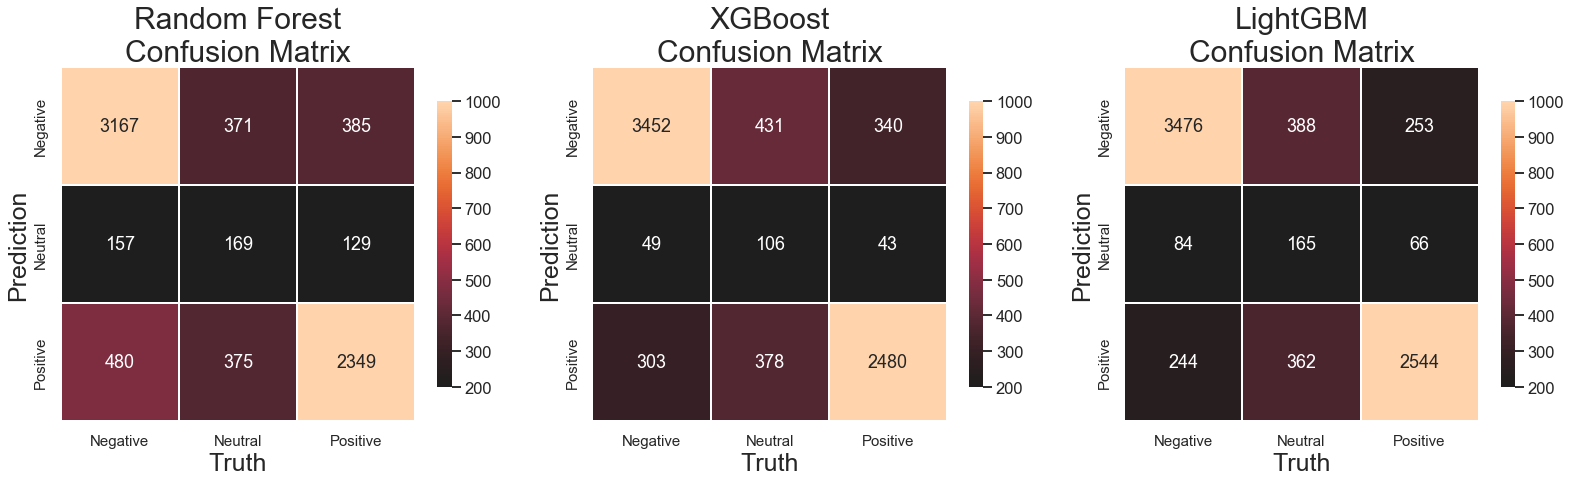

In [63]:
sns.color_palette("bright")
sns.set_context("talk")

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(27, 7))


"""random forest"""
# plot random forest confusion matrix
sns.heatmap(confusion_matrix(y_test, rf_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cbar_kws={"shrink": .75},
### Evaluate model metrics
            ax=ax[0]).set_title('Random Forest\nConfusion Matrix', fontsize=30)

ax[0].set_xlabel('Truth', fontsize=25)
ax[0].set_ylabel('Prediction', fontsize=25)
ax[0].set_xticklabels(['Negative', 'Neutral', 'Positive'], fontsize=15)
ax[0].set_yticklabels(['Negative', 'Neutral', 'Positive'], va='center', fontsize=15)


"""xgboost"""
# plot xgboost confusion matrix
sns.heatmap(confusion_matrix(y_test, xgb_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cbar_kws={"shrink": .75},
            ax=ax[1]).set_title('XGBoost\nConfusion Matrix', fontsize=30)

ax[1].set_xlabel('Truth', fontsize=25)
ax[1].set_ylabel('Prediction', fontsize=25)
ax[1].set_xticklabels(['Negative', 'Neutral', 'Positive'], fontsize=15)
ax[1].set_yticklabels(['Negative', 'Neutral', 'Positive'], va='center', fontsize=15)


"""LMGB"""
# plot LightGBM confusion matrix

sns.heatmap(confusion_matrix(y_test, lgbm_test_preds).T,
            square=True,
            annot=True,
            fmt='d',
            linewidths=1,
            vmin=200, vmax=1000, center=200,
            cbar_kws={"shrink": .75},
            ax=ax[2]).set_title('LightGBM\nConfusion Matrix', fontsize=30)

ax[2].set_xlabel('Truth', fontsize=25)
ax[2].set_ylabel('Prediction', fontsize=25)
ax[2].set_xticklabels(['Negative', 'Neutral', 'Positive'], fontsize=15)
ax[2].set_yticklabels(['Negative', 'Neutral', 'Positive'], va='center', fontsize=15)


plt.savefig(fname='../images/conf_mtrx', bbox_inches='tight', pad_inches=.1)
plt.show()

## Feature Importance

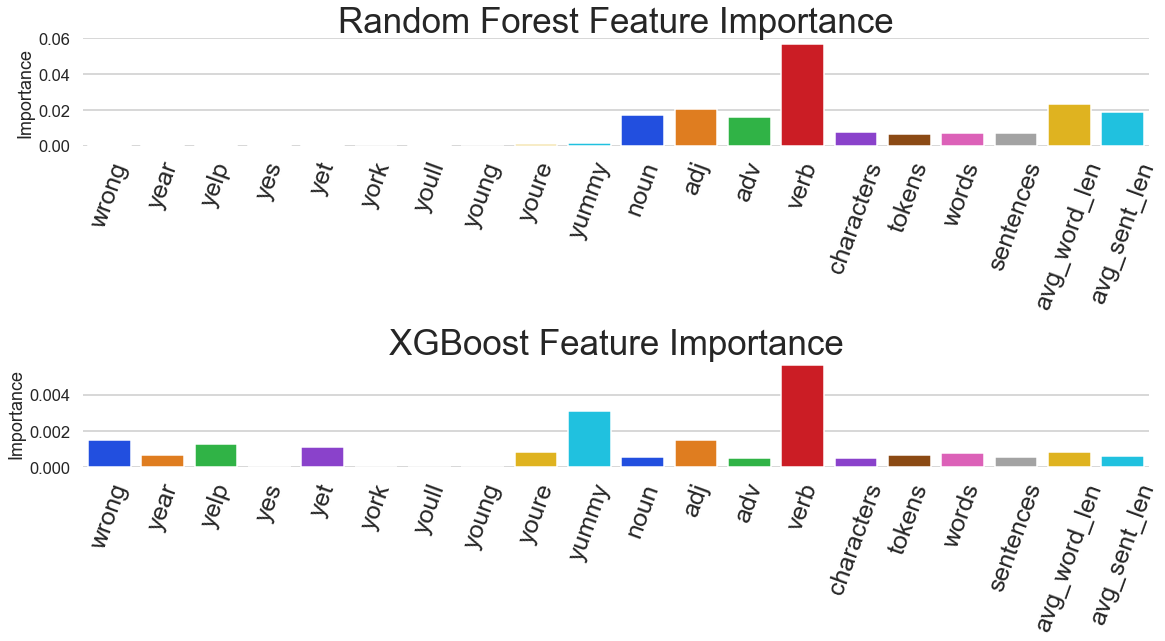

In [65]:
sns.color_palette("bright")
sns.set_style('whitegrid')
sns.set_context("paper")
sns.set_context("talk")

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 7))
fig.tight_layout()
plt.subplots_adjust(hspace=2)


"""random forest"""
# plot random forest feature importance
sns.despine(left=True, bottom=True)
sns.barplot(x=X_train.columns[-20:],
            y=rf_classifier.feature_importances_[-20:],
            palette='bright',
            ax=ax[0]).set_title('Random Forest Feature Importance', fontsize=35)

ax[0].set_ylabel('Importance')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=70, fontsize=25)

"""xgboost"""
# plot xgboost feature importance
sns.despine(left=True, bottom=True)
sns.barplot(x=X_train.columns[-20:],
            y=xgb_classifier.feature_importances_[-20:],
            palette='bright',
            ax=ax[1]).set_title('XGBoost Feature Importance', fontsize=35)

ax[1].set_ylabel('Importance')
ax[1].set_xticklabels(ax[0].get_xticklabels(), rotation=70, fontsize=25)

    
plt.savefig(fname='../images/importance', bbox_inches='tight', pad_inches=.1)
plt.show()